<center><h1>Fine-tuning Image Transformers using Learnable Memory</h1></center>

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import transformers
from transformers import ViTModel, ViTConfig, ViTForImageClassification
from tqdm.auto import tqdm
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
from copy import deepcopy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories for cache and datasets
home_dir = os.path.expanduser('~')
cache_dir = os.path.join(home_dir, "ceng502")
datasets_dir = os.path.join(home_dir, "datasets")

# Uncomment if you don't want to see warnings
# transformers.logging.set_verbosity_error()

In [3]:
def pretrained_model(
        model_name = 'google/vit-base-patch32-224-in21k',
        num_classes = 10,
        ):
    config = ViTConfig.from_pretrained(model_name, num_labels=num_classes, cache_dir=cache_dir)
    model = ViTForImageClassification.from_pretrained(model_name, config=config, cache_dir=cache_dir)
    model = model.to(device)
    return model

# Datasets

In [4]:
# Load and preprocess the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 64

# CIFAR10
cifar10_train_dataset = datasets.CIFAR10(root=datasets_dir, train=True, transform=transform, download=True)
cifar10_train_loader = DataLoader(dataset=cifar10_train_dataset, batch_size=batch_size, shuffle=True)
cifar10_validation_dataset = datasets.CIFAR10(root=datasets_dir, train=False, transform=transform, download=True)
cifar10_validation_loader = DataLoader(dataset=cifar10_validation_dataset, batch_size=batch_size, shuffle=False)

# CIFAR100
cifar100_train_dataset = datasets.CIFAR100(root=datasets_dir, train=True, transform=transform, download=True)
cifar100_train_loader = DataLoader(dataset=cifar100_train_dataset, batch_size=batch_size, shuffle=True)
cifar100_validation_dataset = datasets.CIFAR100(root=datasets_dir, train=False, transform=transform, download=True)
cifar100_validation_loader = DataLoader(dataset=cifar100_validation_dataset, batch_size=batch_size, shuffle=False)

# MNIST
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
mnist_train_dataset = datasets.MNIST(root=datasets_dir, train=True, transform=transform, download=True)
mnist_train_loader = DataLoader(dataset=mnist_train_dataset, batch_size=batch_size, shuffle=True)
mnist_validation_dataset = datasets.MNIST(root=datasets_dir, train=False, transform=transform, download=True)
mnist_validation_loader = DataLoader(dataset=mnist_validation_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Training and Validation Code

In [5]:
def train(model, optimizer,
          dataloader,
          # The index of output head. For MemoryCapableViT only.
          output_head=None,
          num_epochs = 10,
         ):
    model.train()
    criterion = nn.CrossEntropyLoss()
    losses = []
    for epoch in tqdm(range(num_epochs), leave=False):
        train_loss = 0.0
        for batch_idx, (data, targets) in enumerate(tqdm(dataloader, leave=False)):
            data = data.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(data)
            if output_head is not None:
                outputs = outputs[output_head]
            loss = criterion(outputs.logits, targets)
            loss_val = loss.detach().cpu().item()
            losses.append(loss_val)
            train_loss += loss_val

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss}")

        clear_output(wait=True)
        plt.plot(losses)
        plt.show()

In [6]:
def validate(model, dataloader, output_head=None):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data, targets in tqdm(dataloader, leave=False):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            if output_head is not None:
                outputs = outputs[output_head]
            _, predicted = torch.max(outputs.logits, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    return correct / total

# Full Finetuning

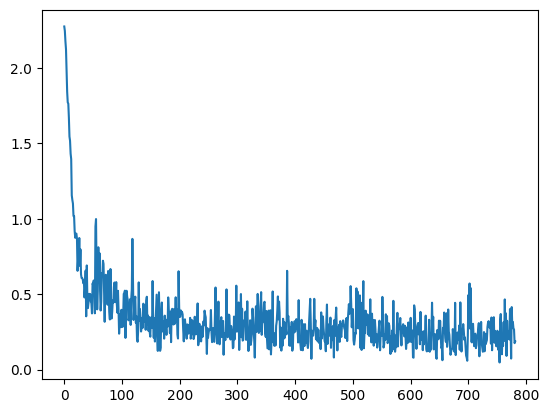

In [7]:
model = pretrained_model()
train(model, optim.Adam(model.parameters(), lr=3e-4), cifar10_train_loader, num_epochs=1)

In [8]:
validate(model, cifar10_validation_loader)

  0%|          | 0/157 [00:00<?, ?it/s]

0.9254

# Class+Head Only Finetuning


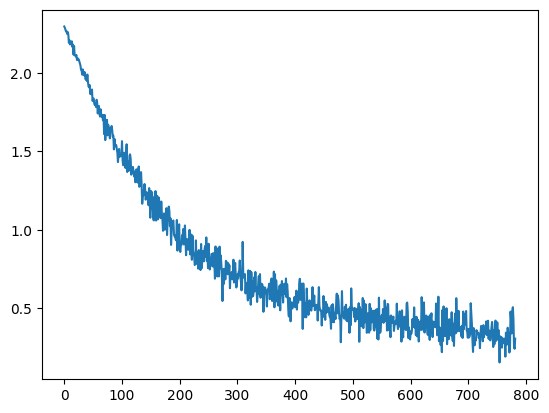

In [7]:
model = pretrained_model()
train(model,
      optim.Adam([model.vit.embeddings.cls_token] + list(model.classifier.parameters()), lr=3e-4),
      cifar10_train_loader,
      num_epochs=1,
     )

In [8]:
validate(model, cifar10_validation_loader)

  0%|          | 0/157 [00:00<?, ?it/s]

0.9305

This will be used as a base model for the next experiment.

In [9]:
base_model = model

# Memory Token

First we convert our model to a `MemoryCapableViT`. This makes it possible to add new classification heads with memory tokens. It also takes care of the attention masking.

In [10]:
from vit import MemoryCapableViT
model = MemoryCapableViT(deepcopy(base_model))

By default, wrapping a `ViTForImageClassification` into `MemoryCapableViT` doesn't change anything apart from some under-the-hood modifications (e.g. class token is inserted at the end instead of the beginning).

Let's check whether they are actually equivalent by running the validation again. Note that since `MemoryCapableViT` can have multiple heads, we need to specify which head's output to use. Since we currently have only one head, its index is 0.

In [12]:
validate(model, cifar10_validation_loader, output_head=0)

  0%|          | 0/157 [00:00<?, ?it/s]

0.9305

As expected, this accuracy value is the same as before.

For a more rigorous verification, there's a unit test in `test_vit.py` which checks the value of output. You can run all available unit test with `pytest`.

## Add new classification head with memory

We can now add a new classification head to our model.

We will train the new head for CIFAR100 which has 100 classes. There will be 4 memory tokens in each self-attention layer.

In [13]:
new_parameters = model.add_head(memory_tokens=1, num_classes=100)

The new parameters are returned as a list:
- The new class token. Shape: `[1, 1, 768]`.
- All memory tokens, one for each self-attention layer. We have 12 self-attention layers. Each has shape `[1, memory_tokens, 768]`.
- Weights (of size `[100, 768]`) and biases (of size `[100]`) of the new classifier head.

Let's print shapes of these parameters:

In [14]:
[p.size() for p in new_parameters]

[torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([1, 1, 768]),
 torch.Size([100, 768]),
 torch.Size([100])]

After calling the `add_head` method, the attention mask will be updated automatically. This makes sure that the old class tokens don't interact with the new class and memory tokens.

<img src="images/attention-mask.png" alt="Attention Mask Figure" style="width: 500px;"/>

Let's check whether our attention mask matches the table above. Note that we currently have $\text{INP}$, $\text{CLS}$, $C_1$ and $M_1$ in our network.

In [15]:
model.vit.encoder.layer[0].attention.attention.attention_mask[0, 48:, 48:]

tensor([[0., 0., -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., 0.]], device='cuda:0')

This attention mask is added to the computed attention scores before the softmax is applied.

In self-attention layer, we don't insert the memory tokens while calculating the query. Therefore, memory tokens will not attend to other tokens and they won't be present in the output of the self-attention. This also ensures that the attention scores matrix has the same shape as the attention mask.

Let's train the new parameters:

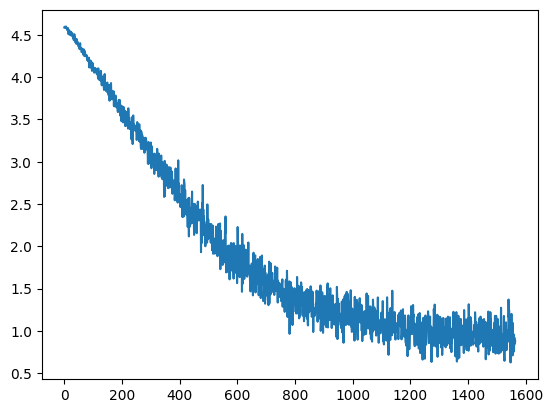

In [16]:
train(model,
      optim.Adam(new_parameters, lr=3e-4),
      cifar100_train_loader,
      output_head=1,  # The index of newly added head is 1
      num_epochs=2,
     )

In [17]:
validate(model, cifar100_validation_loader, output_head=1)

  0%|          | 0/157 [00:00<?, ?it/s]

0.7922

The performance of the previous head should not be affected thanks to attention masking.

In [18]:
validate(model, cifar10_validation_loader, output_head=0)

  0%|          | 0/157 [00:00<?, ?it/s]

0.9305

# Model Concatenation

Suppose that someone else took the same pretrained network and fine-tuned it on another dataset with memory tokens.

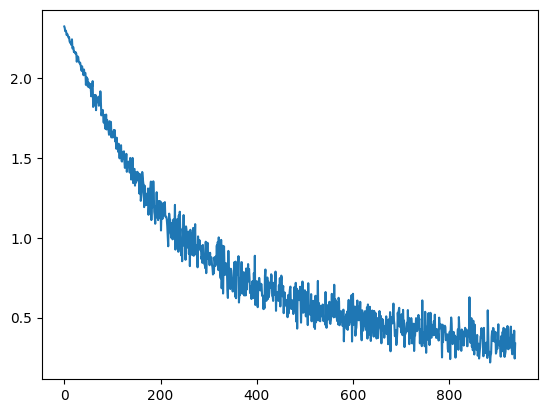

In [19]:
model2 = MemoryCapableViT(deepcopy(base_model))
new_parameters = model2.add_head(memory_tokens=1, num_classes=10)
train(model2,
      optim.Adam(new_parameters, lr=3e-4),
      mnist_train_loader,  # We are finetuning on MNIST now
      output_head=1,  # The index of newly added head is 1
      num_epochs=1,
     )

In [20]:
validate(model2, mnist_validation_loader, output_head=1)

  0%|          | 0/157 [00:00<?, ?it/s]

0.9281

Normally, models exhibit lower performance on the previous dataset after finetuning on a different dataset and separately finetuned models cannot be combined. However, we can achieve all of these with learnable memory method!

<img src="images/model-concat.png" alt="Model Concatenation Figure" style="width: 600px;"/>

`MemoryCapableViT` offers `concatenate` method. It merges two separately finetuned models. This method operates on the model in-place to use less memory.

In [21]:
model.concatenate(model2)

The combined model has 3 heads: the first one is the original, trained on CIFAR10; the second one trained on CIFAR100; and finally the third one for MNIST. We can now accoplish all of these tasks with a single model without any performance penalty.

In [22]:
validate(model, cifar10_validation_loader, output_head=0)

  0%|          | 0/157 [00:00<?, ?it/s]

0.9305

In [23]:
validate(model, cifar100_validation_loader, output_head=1)

  0%|          | 0/157 [00:00<?, ?it/s]

0.7922

In [25]:
validate(model, mnist_validation_loader, output_head=2)

  0%|          | 0/157 [00:00<?, ?it/s]

0.9281

If we inspect the attention mask of the combined model, we should see Table 1 with $\text{INP}$, $\text{CLS}$, $C_1$, $M_1$, $C_2$ and $M_2$ columns.

In [26]:
model.vit.encoder.layer[0].attention.attention.attention_mask[0, 48:, 48:]

tensor([[0., 0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, 0., -inf],
        [0., 0., -inf, 0., -inf, 0.]], device='cuda:0')